# A simple example on how to use `scopes`

In this tutorial you will learn the basic functionality of SCOPES and how to set everything up to use it.

## Topics

- Construct the "Night" object to designate the specific night of the year for which the schedule is to be created.
- Establish the observing programs, outlining their specific objectives and parameters.
- Determine the merits to be utilized, ensuring they align with the objectives of the observing programs.
- Create the "Target" objects, assigning appropriate merits based on the unique requirements of each target.
- Create the "Observation" objects which are the objects to create the Schedule.
- Test the scheduler by creating a simple and short schedule of just 3 observations to see how it works.
- Create a more extended sample of Targets to create a simulation of a full night of observations.

## Setup

### Imports

In [1]:
from scopes.scheduler_components import (
    Night,
    Program,
    Merit,
    Target,
    Observation,
    Overheads,
)
from scopes import merits
from scopes import scheduler

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
from datetime import date
from astropy.coordinates import SkyCoord
import astroplan

### Observer and Night

We will start by defining the Observer, that is where in the world our telescope is located, and for which night we want to create a schedule. This is done using the Observer object from the `astroplan` package. For this example we will consider a telescope at the La Silla Observatory in Chile.

We then create the Night object for which night we want to create the schedule. This is done by defining the date and within which twilights observations should be considered.

NOTE: The `night_date` refers to the date when the night starts at the telescope's location, according to local time. This is important as, depending on the time zone, the UTC date might differ. For instance, if a night in Chile begins at 21:15 hs local time on November 14, 2024, the `night_date` is considered to be November 14, 2024 (even though in UTC this time and date corresponds to 00:15hs on Novemeber 15, 2025).

In [2]:
# Define observer location
observer = astroplan.Observer.at_site("La Silla Observatory")

# Define the night
night = Night(date(2023, 11, 14), "nautical", observer)

### Programs

SCOPES allows to define different observing programs. This is widely the case in many telescopes where different groups use the telescope for different purposes and thus each group or person has their own observing program with their own set of targets and scientific priorities.

These are defined with the `Program` object where the parameters to be given are the program ID, name of the instrument to be used, the proprotion of the total time that is allocated to this program, and optionally with what color this program will be plotted.

In [3]:
# Define color pallette for plotting
color_pallette = iter([mcolors.rgb2hex(color) for color in plt.get_cmap("Set2").colors])

# The parameters are:
# 1. Name of the program
# 2. The instrument this program will use
# 3. Priority of the program
# 4. Time share allocated to the program
# 5. (optional) Plot color
# Lets use "GUITAR" and "PIANO" as our two example instruments
prog1 = Program("prog1", 1, 0.1, plot_color=next(color_pallette))
prog2 = Program("prog2", 2, 0.1, plot_color=next(color_pallette))
prog3 = Program("prog3", 2, 0.3, plot_color=next(color_pallette))
prog4 = Program("prog4", 3, 0.2, plot_color=next(color_pallette))
prog5 = Program("prog5", 2, 0.3, plot_color=next(color_pallette))

Now we will tell SCOPES how much time each of these programs have taken up already. This is done by calling the `set_current_time_usage()` method on each program and indicating the current time used by that program (as a percentage of the total time).

To simulate a somewhat real situation, lets asume that prog1 and prog3 were observed less than was allocated to them, prog4 is close to even, while prog2 and prog5 were observed more than the time they were allocated.

In [4]:
prog1.set_current_time_usage(0.15)
# prog2.set_current_time_usage(0.13)
prog3.set_current_time_usage(0.35)
prog4.set_current_time_usage(0.10)
# prog5.set_current_time_usage(0.39)

### Merits

Now we will define the set of merits we will be using. Some standard merit functions can be found in the `scopes.merits` module, but custom ones can be defined as well.

The Merit class takes three mandatory arguments, `name`, `func`, and `merit_type`. `func` is the function that actually computes the merit from an observation, `merit_type` tells the scheduler how to use the merit in the rank function, i.e. if its a fariness, veto, or efficiency merit. Then the optional `paramteres` arguments gives the function any additional keyword arguments for that merit. This allows to create merits that use the same merit function but with a different set of parameters.

In [5]:
night.civil_evening

np.float64(2460263.486185421)

In [6]:
# We will start with the basic observability merits like limits on the airmass, altitude, and time of night.

# Lets define a merit for the airmass setting a maximum of 1.8
airmass_merit_1 = Merit(
    "Airmass", merits.airmass, merit_type="veto", parameters={"limit": 1.6}
)

# Lets define a merit for the airmass setting a maximum of 1.5
airmass_merit_2 = Merit(
    "Airmass", merits.airmass, merit_type="veto", parameters={"limit": 1.5}
)

# Lets define a merit for the altitude. These are usually set by the hardware limits of the telescope.
# In this exmaple we will use a minimum of 20 and a maximum of 87 degrees (to avoid the zenith
# which can cause tracking issues in telescopes with an altazimuth mount)
altitude_merit = Merit(
    "Altitude", merits.altitude, merit_type="veto", parameters={"min": 20, "max": 87}
)

# Lets define a merit for the time of night. These limits are used from the Night object we created above.
at_night_merit = Merit("AtNight", merits.at_night, merit_type="veto")

# Now we will define a merit for the moon separation. This merit will ensure that the moon is at least
# 30 degrees away from the target.
moon_sep_merit = Merit(
    "MoonSep",
    merits.moon_separation,
    merit_type="veto",
    parameters={"theta_lim": 20, "theta_start": 30, "alpha": 3},
)

# The Culmination merit is used to ensure observations are done close to the culmination of the target in the sky.
culmapping_merit = Merit(
    "CulMapping", merits.culmination_efficiency, merit_type="efficiency"
)

phase_merit = Merit(
    "PhaseSpecefic",
    merits.phase_specific,
    merit_type="efficiency",
    parameters={"period": 1, "epoch": 2460263.48618, "phases": [0.1], "sigma": 0.2},
)

# Lastly, we will deifne a fairness merit for the time share. This merit ensures that programs
# respect the time share they are given.
timeshare_merit = Merit("Timeshare", merits.time_share, merit_type="fairness")
priority_merit = Merit("Priority", merits.priority, merit_type="fairness")

Lets define two sets of merits to use later

In [7]:
merits1 = [
    airmass_merit_1,
    altitude_merit,
    at_night_merit,
    # moon_sep_merit,
    culmapping_merit,
    timeshare_merit,
    priority_merit,
    phase_merit,
]

merits2 = [
    airmass_merit_2,
    altitude_merit,
    at_night_merit,
    # moon_sep_merit,
    culmapping_merit,
    timeshare_merit,
    priority_merit,
]

### Overheads

The `Overheads` defines all the overheads that your telescope has when transitioning from one observation to the next. The basic overhead common to all telescopes is the slew time that the telescope takes to move from one position in the sky to the next. 

Then custom overheads can be defined and added to the object. Here any type of overhead can be defined using the properties of the Observations, Targets, Instruments, etc. For the overhead function to be valid is has to have two parameters called `observation1` and `observation2`, where the transition time will be from `observation1` to `observation2`.

When you add your custom overhead function to the Overhead object you can indicate if this overhead time can overlap with the slew time. Meaning if it happens in parallel as the telescope is moving from one position to the next.

If more than one custom overhead is added they are assumed to happen in sequence.

NOTE: This could be improved as the overhead calculation might be complicated. Ideas are welcome.

In [14]:
# We start by initializing the Overheads object with the slew rates of the telescope.
# In this example we will use a slew rate of 2 degrees per second in both axes.
overheads = Overheads(slew_rate_az=1, slew_rate_alt=2)


# We will now define a custom overhead related to the change of instrumnet.
# The overhead function has to take two observations (observation1 and observation2) as input
# and return the overhead time in seconds.
def change_instrument_overhead(observation1: Observation, observation2: Observation):
    if observation1.instrument != observation2.instrument:
        # In this telescope it takes 170 seconds to change the instrument in either direction
        # You can define a more complex function here if you want to have different overheads
        # For example if the change from a camera to a spectrograph might take longer or viceversa
        return 170
    else:
        return 0


# We will add this overhead to the Overheads object later when we create a bigger scenario with multiple instruments

### Targets and Observations

Next we will define the targets to be observed by creating Target objects and then Observation Objects.

The `Target` object contain information about the target itself, like its name, coordinates, which program it is part of, its priority and most importantly its individual merit functions which determine how the target should be observed.

The `Observation` object takes a target as input and adds the exposure time. The reason the Target and Observation objects are distinct is to allow the posisblity to create more than one observation for the same target if needed.

**In this tutorial we will create simulated targets, but in this section is where one would actually load the actual targets that want to be observed.**

## Simple case

Let's start with just 3 targets to see how SCOPES puts the obesrvations together into a schedule.

In [15]:
# We are going to use a start time of just less than the middle of the night
(night.night_time_range[0].jd + night.night_time_range[-1].jd) / 2

np.float64(2460263.6855988586)

In [16]:
# We create the Target object with the name, program, coordinates, and priority
star1 = Target("Star1", prog1, SkyCoord(45, -50, unit="deg"), priority=1)
# We add the merits we want to the target, in this case we are using the merits1 list we defined above
star1.add_merits(merits1)
star2 = Target("Star2", prog1, SkyCoord(52, -50, unit="deg"), priority=1)
star2.add_merits(merits1)
star3 = Target("Star3", prog1, SkyCoord(60, -50, unit="deg"), priority=1)
star3.add_merits(merits1)

# We define an exposure time for the observations
# In this case we will use 1800 seconds (30 minutes)
duration = 1800
obs1 = Observation(star1, duration)
obs2 = Observation(star2, duration)
obs3 = Observation(star3, duration)
test_obs = [obs1, obs2, obs3]

In [17]:
# Initialize the scheduler
gQ_scheduler = scheduler.generateQ(
    night, test_obs, overheads, plan_start_time=2460263.66
)

Preparing observations for scheduling...


Setting up observations:   0%|          | 0/3 [00:00<?, ?it/s]

NOTE: Implement end of plan as a precise time

In [18]:
# Run the scheduler and create the plan
test_plan = gQ_scheduler.run(max_plan_length=None, K=2)

Creating the Plan...
Done!


In [19]:
test_plan.print_stats()

Length = 3
Score = 1.037569
Evaluation = 1.003515
Observation time = 1:30:00
Overhead time = 0:00:27.124938
Observation ratio = 0.99500
Overhead ratio = 0.00500
Avg airmass = 1.07028


In [20]:
print(test_plan)

  Instrument ProgID Target        RA        DEC Start Time  Exp Time  Exp Time (s) Comment
0             prog1  Star1  03:00:00  -50:00:00   03:50:24  00:30:00          1800        
1             prog1  Star2  03:28:00  -50:00:00   04:20:36  00:30:00          1800        
2             prog1  Star3  04:00:00  -50:00:00   04:50:51  00:30:00          1800        


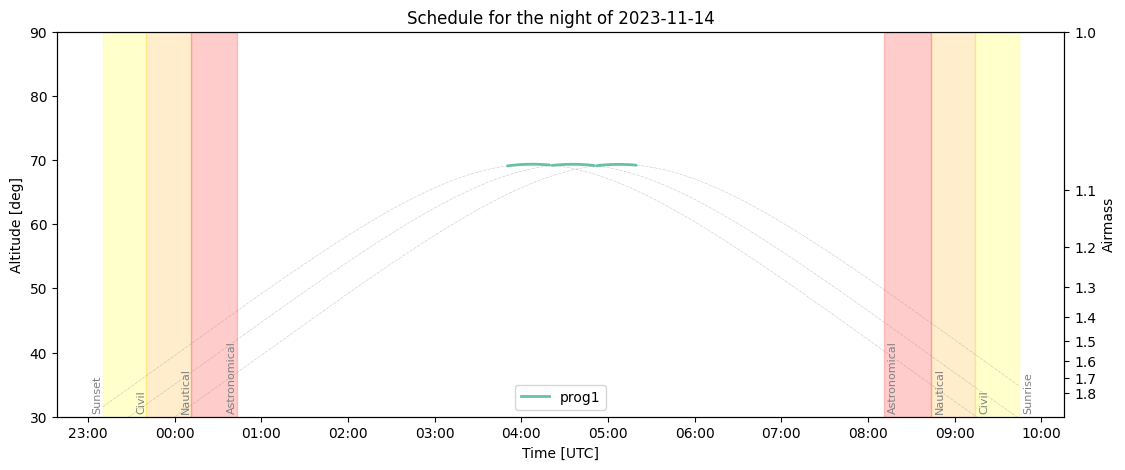

In [21]:
test_plan.plot()

We see that the scheduler has put the observations in the correct order to maximise the airmass of each.

## Full night schedule

Now let's create a full night schedule with stars from all programs and instruments

In [22]:
# Generate random star coordinates
np.random.seed(0)
ntars = 100

# Right ascension angle range that is visible from La Silla on the night of 2023-11-14 is roughly
# between 0 and 160, and 300 to 360 degrees
ra = np.random.uniform(300, 520, size=ntars) % 360
dec = -np.rad2deg(np.arcsin(np.random.uniform(0, 1, size=ntars)))

# We will initialize the observations start time at the start of the night
start_time = night.night_time_range[0].jd


# Create Observations objects
def create_tars_and_obs(prog, idx_range, merits, instrument):
    observations = []
    for i in range(idx_range[0], idx_range[1]):
        # Get the coordinates for the target
        coord = SkyCoord(ra[i], dec[i], unit="deg")
        # Create the Target object with a random priority
        target = Target(f"Target{i}", prog, coord, np.random.randint(0, 4))
        # Add the merits to the target
        target.add_merits(merits)

        # Create the observation

        duration = np.random.randint(300, 1200)
        observation = Observation(target, duration, instrument)
        observations.append(observation)
    return observations

Now lets create the Observations for each program. Let's assume that prog1 and prog2 need their targets to be observed at a maximum airmass of 1.5 as they need a good SNR. In contrast, prog3, prog4, and prog5 are not that sensitive to SNR and allows their targets to be observed up to an airmass of 1.8.

In [23]:
obs_prog1 = create_tars_and_obs(prog1, (0, 20), merits1, instrument="GUITAR")
obs_prog2 = create_tars_and_obs(prog2, (20, 40), merits1, instrument="GUITAR")
obs_prog3 = create_tars_and_obs(prog3, (40, 60), merits1, instrument="GUITAR")
obs_prog4 = create_tars_and_obs(prog4, (60, 80), merits2, instrument="PIANO")
obs_prog5 = create_tars_and_obs(prog5, (80, 100), merits2, instrument="PIANO")

all_obs = obs_prog1 + obs_prog2 + obs_prog3 + obs_prog4 + obs_prog5

We will add the instrument change overhead now to the overheads as more than one instrument is involved in this schedule

In [24]:
overheads.add_overhead(change_instrument_overhead, can_overlap_with_slew=True)

### Scheduling the night

We have set up everything we need to now create the night sschedule based on the observations we created.

To do this we will initialize a Scheduler object from the `scopes.scheudler` module. To start we will use the simple generateQ scheduler which works based on a simple greedy search algorithms which works sequentially from the beginning of the night and always chooses the best scoring observation as the next observation to do.

In [25]:
# Initialize the scheduler
# Leaving the plan_start_time as None will set it to the start of the observable night
gQ_scheduler = scheduler.generateQ(night, all_obs, overheads)

Preparing observations for scheduling...


Setting up observations:   0%|          | 0/100 [00:00<?, ?it/s]

In [26]:
# Run the scheduler and create the plan
plan = gQ_scheduler.run(max_plan_length=None, K=3)

Creating the Plan...
Done!


In [27]:
plan.print_stats()

Length = 36
Score = 0.928026
Evaluation = 0.919477
Observation time = 7:49:55
Overhead time = 0:42:20.615626
Observation ratio = 0.91734
Overhead ratio = 0.08266
Avg airmass = 1.21612


A plan can be printed by simply calling `print()` on it:

In [28]:
print(plan)

   Instrument ProgID    Target        RA        DEC Start Time  Exp Time  Exp Time (s) Comment
0       PIANO  prog5  Target92  21:55:59  -10:43:51   00:11:01  00:06:52           412        
1       PIANO  prog5  Target87  21:22:40  -36:09:02   00:19:00  00:19:45          1185        
2      GUITAR  prog2  Target34  20:16:32  -34:44:52   00:41:35  00:13:37           817        
3      GUITAR  prog1  Target16  20:17:48  -61:46:33   00:55:50  00:19:19          1159        
4      GUITAR  prog3  Target57  23:42:54  -34:41:15   01:15:30  00:10:00           600        
5      GUITAR  prog2  Target26  22:06:09  -01:06:00   01:26:44  00:09:41           581        
6      GUITAR  prog2  Target29  02:04:54  -16:51:45   01:38:27  00:09:36           576        
7      GUITAR  prog1   Target4  02:12:49  -14:24:13   01:48:05  00:11:45           705        
8       PIANO  prog5  Target90  00:40:20  -23:28:01   02:02:40  00:13:52           832        
9       PIANO  prog5  Target80  00:39:50  -09:28:4

This table can be obtained directly by using the .to_df() method which return a pandas DataFrame with the plan details.

In [29]:
plan.to_df()

,Instrument,ProgID,Target,RA,DEC,Start Time,Exp Time,Exp Time (s),Comment
0,PIANO,prog5,Target92,21:55:59,-10:43:51,00:11:01,00:06:52,412,
1,PIANO,prog5,Target87,21:22:40,-36:09:02,00:19:00,00:19:45,1185,
2,GUITAR,prog2,Target34,20:16:32,-34:44:52,00:41:35,00:13:37,817,
3,GUITAR,prog1,Target16,20:17:48,-61:46:33,00:55:50,00:19:19,1159,
4,GUITAR,prog3,Target57,23:42:54,-34:41:15,01:15:30,00:10:00,600,
5,GUITAR,prog2,Target26,22:06:09,-01:06:00,01:26:44,00:09:41,581,
6,GUITAR,prog2,Target29,02:04:54,-16:51:45,01:38:27,00:09:36,576,
7,GUITAR,prog1,Target4,02:12:49,-14:24:13,01:48:05,00:11:45,705,
8,PIANO,prog5,Target90,00:40:20,-23:28:01,02:02:40,00:13:52,832,
9,PIANO,prog5,Target80,00:39:50,-09:28:46,02:17:01,00:15:31,931,


A plan can be saved to a CSV file by callin its `.to_csv()` method. This method calls the to_csv() method of the corresponding pandas DataFrame, which means this method can take any argument that the `pd.DataFrame.to_csv()` method can take.

In [30]:
plan.to_csv("test_plan.csv")

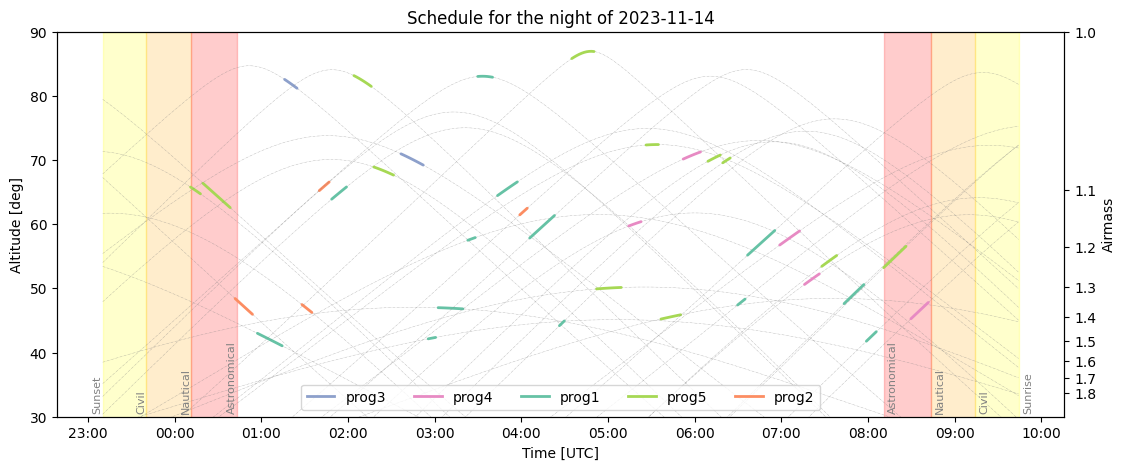

In [31]:
plan.plot()

There are two optional parameter in the .plot() method: display and path, which indicate if the generated plot should be displayed and/or if it should be saved to a file.

In this example we will just save the plot without displaying it (which can be useful if implemented within a larger pipeline where the plot will be shown somewhere else).

In [32]:
plan.plot(display=False, path="test_plan.png")

Polar plots to show the path that the telescope takes along the sky.

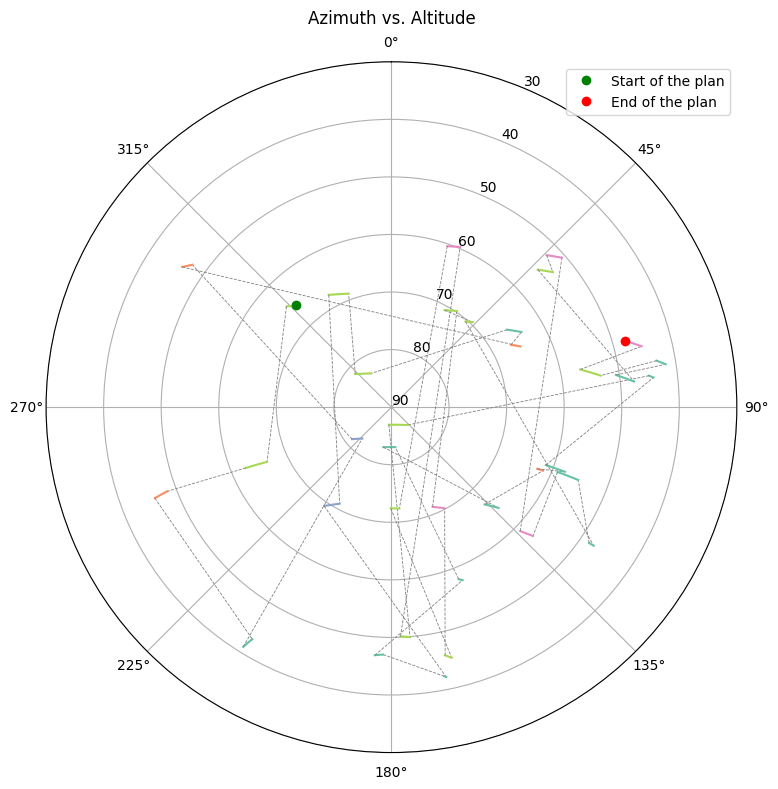

In [33]:
plan.plot_polar(path="test_plan_polar.png")

Lastly the altaz plot, which shows a similar thing than the polar but in linear form and for altitude and azimuth in separate plots.

Here it is also useful to se the duration of the overheads, and how many times its swtiching between instruments.

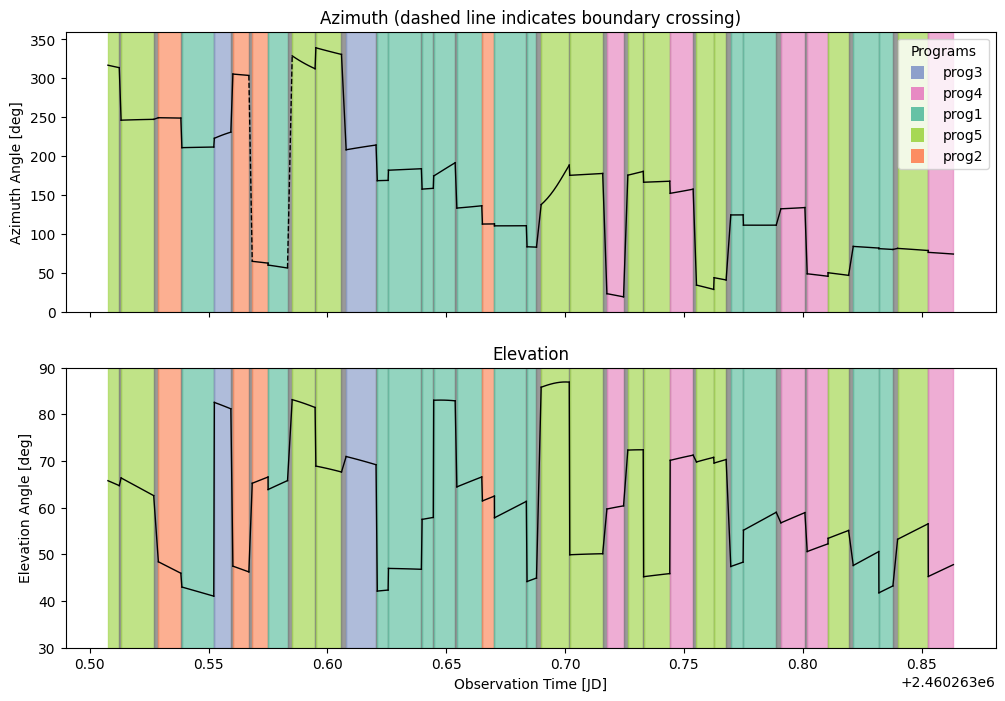

In [34]:
plan.plot_altaz()

### Scheduling only a part of the night

Let's say that we only want to schedule a part of the night. In that case we can add start and end times for the schedule and it will only schedule observations between the two selected times.

These variables (`plan_start_time` and `plan_end_time`) are optional and their default values are the start and end of the observable night respectively. So you can also only indicate a start time and schedule until the end of the night, or inversly, ony indicate and end time in which case it will schedule fromthe beginning of the night until the indicated time.

In [35]:
night.obs_within_limits

array([2460263.50765796, 2460263.86353976])

In [36]:
# Initialize the scheduler
# Leaving the plan_start_time as None will set it to the start of the observable night
gQ_scheduler = scheduler.generateQ(
    night, all_obs, overheads, plan_start_time=2460263.6, plan_end_time=2460263.75
)

Preparing observations for scheduling...


Setting up observations:   0%|          | 0/100 [00:00<?, ?it/s]

In [37]:
# Run the scheduler and create the plan
subplan = gQ_scheduler.run(K=5)

Creating the Plan...
Done!


In [38]:
subplan.print_stats()

Length = 17
Score = 1.002694
Evaluation = 0.951063
Observation time = 3:20:43
Overhead time = 0:13:13.899513
Observation ratio = 0.93815
Overhead ratio = 0.06185
Avg airmass = 1.11818


In [39]:
print(subplan)

   Instrument ProgID    Target        RA        DEC Start Time  Exp Time  Exp Time (s) Comment
0      GUITAR  prog3  Target58  02:50:21  -24:01:41   02:24:00  00:19:49          1189        
1      GUITAR  prog2  Target29  02:04:54  -16:51:45   02:44:36  00:09:36           576        
2      GUITAR  prog1   Target4  02:12:49  -14:24:13   02:54:16  00:11:45           705        
3      GUITAR  prog3  Target48  00:37:35  -45:34:52   03:08:34  00:18:06          1086        
4      GUITAR  prog1   Target6  02:25:05  -36:18:07   03:27:33  00:13:00           780        
5      GUITAR  prog1  Target11  03:45:26  -57:49:23   03:41:06  00:06:46           406        
6      GUITAR  prog1   Target0  04:02:57  -42:40:24   03:48:20  00:09:34           574        
7      GUITAR  prog1  Target12  04:19:53  -44:23:07   03:57:56  00:15:06           906        
8      GUITAR  prog2  Target37  05:02:54  -40:47:00   04:13:19  00:07:19           439        
9      GUITAR  prog1   Target5  05:28:23  -35:10:5

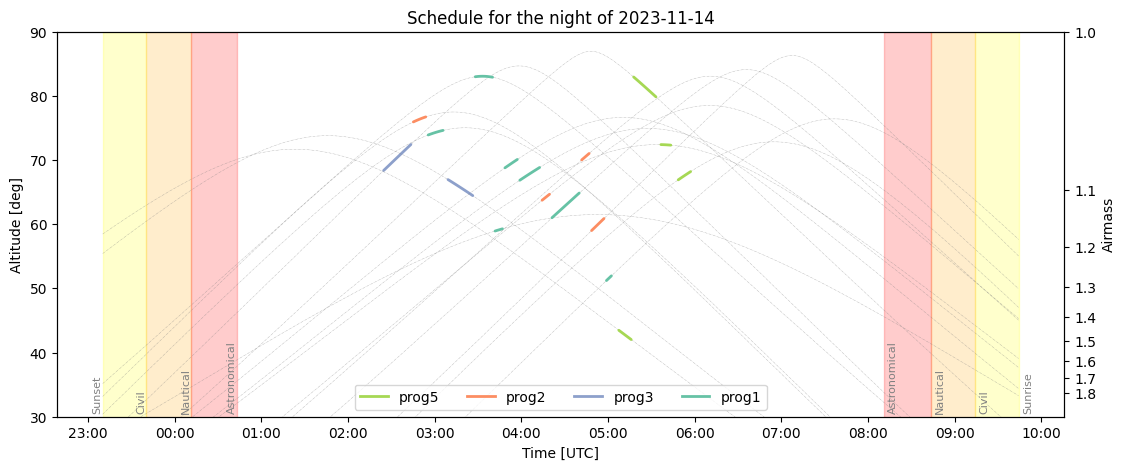

In [40]:
subplan.plot()

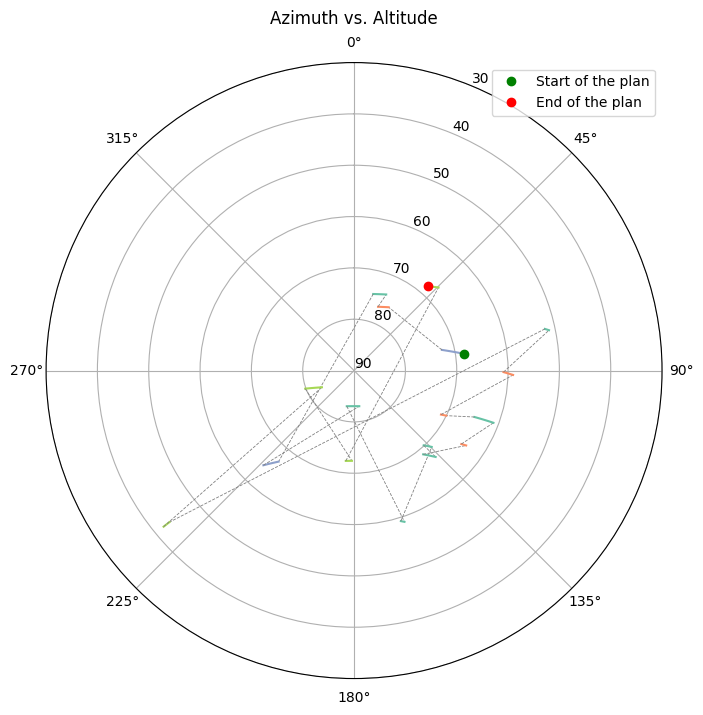

In [41]:
subplan.plot_polar()

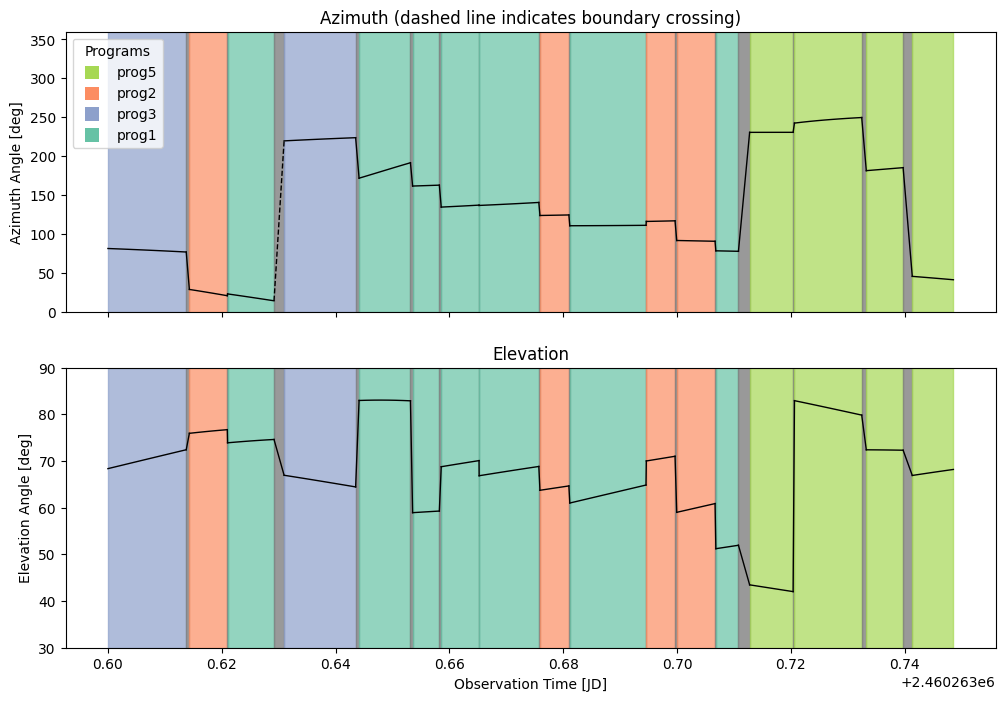

In [42]:
subplan.plot_altaz()

## Test different schedulers

**ATTENTION: These are experimental schedulers that can be slow and lower performing than the standard `generateQ` scheduler**

Let's try some other type of scheduling algorithms. These can be created customly by creating a new class that inherits from the base `Scheduler` class and includes a `run()` method that creates a Plan from the provided list of observations.

Here we will test the Dynamic Programming Planner (`DPPlanner`) and the `BeamSearchPlanner` schedulers.

### Dynamic Programming Planner (`DPPlanner`)

In [37]:
# Initialize the scheduler
# Leaving the plan_start_time as None will set it to the start of the observable night
# dp_scheduler = scheduler.DPPlanner(night, all_obs, overheads)

In [38]:
# Reset the DP scheduler by clearing the cache (only needed when re-running the scheduler)
# dp_scheduler.reset_dp()
# Run the scheduler and create the plan
# plan_dp = dp_scheduler.run(max_plan_length=10, K=2)

In [39]:
# plan_dp.print_stats()

In [40]:
# print(plan_dp)

In [41]:
# plan_dp.plot()

### Beam Search Planner (`BeamSearchPlanner`)

The BeamSearchPlanner algorithm can be visualized as navigating a decision tree where each node represents a potential observation plan, and each branch signifies adding an observation. Starting from the root (an empty plan), the algorithm explores various branches, but instead of examining every possible path, it employs a "beam" strategy to keep only the top K most promising branches at each level, effectively pruning the rest. This selective exploration ensures that the tree does not grow too large and unwieldy, focusing computational resources on extending only the most promising plans. As the algorithm progresses down the tree, it continuously evaluates and updates the best plan based on a scoring system, until it either reaches the maximum plan length or no further promising branches exist, culminating in the most optimal schedule of observations within the given constraints.

In [42]:
# Initialize the scheduler
# Leaving the plan_start_time as None will set it to the start of the observable night
# bs_scheduler = scheduler.BeamSearchPlanner(night, all_obs, overheads)

In [43]:
# Run the scheduler and create the plan
# bs_plan = bs_scheduler.run(max_plan_length=10, K=5)

In [44]:
# bs_plan.print_stats()

In [45]:
# print(bs_plan)

In [46]:
# bs_plan.plot()